In [1]:
# Generic Dependencies
import numpy as np
from numpy import arange
import pandas as pd
from pandas import set_option
# from pandas.tools.plotting import scatter_matrix
import os

# Plotting Libraries
from matplotlib import pyplot as plt
import seaborn as sns

# SKLearn Libraries
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Lasso, LassoCV, Ridge,RidgeCV
from sklearn.model_selection import cross_validate

# library for saving models
from sklearn.externals import joblib

from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.metrics import mean_squared_error

# DictVectorizer
from sklearn.feature_extraction import DictVectorizer

#XGBoost libraries
import xgboost as xgb

# explain xgboost preiction and model
import shap


# import generateXdata.py to prepare the data
# from generateXdata import generateX
from generateXdataExt import generateX_samp

#Import Custom ml models
from Cls_ml_models import ml_models_tuned


In [2]:
# gobal variables
dataFilePath = "dataforfinalproject"
filename = "sampletest.csv"
cols_file = "Final_Columns_withCat.csv"
sample = "SAMPLE 5"

totsqt = {0 : "(df_recs.TOTHSQFT != -1)",
             1 : "(df_recs.TOTHSQFT < 900)",
             2 : "((df_recs.TOTHSQFT >= 900) & (df_recs.TOTHSQFT < 1500))",
             3 : "((df_recs.TOTHSQFT >= 1500) & (df_recs.TOTHSQFT < 2500))",
             4 : "((df_recs.TOTHSQFT >= 2500) & (df_recs.TOTHSQFT < 3500))",
             5 : "(df_recs.TOTHSQFT >= 3500)"}


In [3]:
X, vocab, y = generateX_samp(ohe = True, target = "DOLLAR", numSamples = 30, region = 2, totsqft_cd = 3)

       RECSYEAR        COUNTRY  DOEID  REGIONC REGIONNAME  DIVISION  \
297        2001  United States   1310        2    Midwest         3   
6023       2009  United States   1457        2    Midwest         3   
1734       2001  United States   2798        2    Midwest         3   
18422      2015  United States  12543        2    Midwest         4   
5131       2009  United States    501        2    Midwest         4   
19235      2015  United States  13387        2    Midwest         3   
9381       2009  United States   5066        2    Midwest         4   
16529      2015  United States  10581        2    Midwest         3   
1967       2001  United States   3043        2    Midwest         4   
12784      2009  United States   8684        2    Midwest         3   
3410       2001  United States   4545        2    Midwest         4   
243        2001  United States   1252        2    Midwest         3   
21116      2015  United States  15348        2    Midwest         3   
10880 

In [4]:
# pd.DataFrame(X,columns = vocab).to_csv(os.path.join("dataforfinalproject/InputSamples.csv"), index = True)

In [5]:
# df_recs = pd.read_csv(os.path.join(dataFilePath, filename), low_memory= False)


# df_recs[(eval(totsqt[3]))]

# df_recs[(df_recs.REGIONC == 2) & (eval(totsqt[3]))].sample( n = 10)

In [6]:
y

297      2356.00
6023     1989.00
1734      904.00
18422    1573.50
5131     1508.00
19235    2009.23
9381     1294.00
16529    2394.98
1967     1082.00
12784    2133.00
3410     1737.00
243      1708.00
21116    1263.03
10880    3059.00
1295     1388.00
13767    2501.00
18329    2139.09
13942    2241.00
10402    2042.00
954      1335.00
17062    1496.40
5013     3254.00
1969     3567.00
3551     1060.00
7355     2136.00
17736    1139.36
13071    1057.00
20952    1715.24
14186    1834.00
15096    2568.00
Name: TOTALDOLLAR, dtype: float64

In [7]:
# load the model into a list
model_name = ["Classic Lasso","Elasticnet", "LassoCV", "LR","RF", "RidgeCV","XGB"]
models = [joblib.load(os.path.join("final_models",file)) for file in os.listdir("final_models") if file.endswith("sav")]

In [8]:
models

[Lasso(alpha=0.01, copy_X=True, fit_intercept=True, max_iter=1000,
    normalize=False, positive=False, precompute=False, random_state=None,
    selection='cyclic', tol=0.0001, warm_start=False),
 ElasticNet(alpha=0.003, copy_X=True, fit_intercept=True, l1_ratio=0.5,
       max_iter=1000, normalize=False, positive=False, precompute=False,
       random_state=None, selection='cyclic', tol=0.0001, warm_start=False),
 LassoCV(alphas=None, copy_X=True, cv=10, eps=0.001, fit_intercept=True,
     max_iter=100000, n_alphas=100, n_jobs=None, normalize=True,
     positive=False, precompute='auto', random_state=None,
     selection='cyclic', tol=0.0001, verbose=False),
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
          normalize=False),
 RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=11,
            max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,

In [9]:
X

array([[  2. ,   4. ,   4. , ..., 250. ,   3. ,   3. ],
       [  3. ,   2. ,   2. , ...,   1. ,   3. ,   1. ],
       [  1. ,   4. ,   5. , ...,   0. ,   3. ,   7. ],
       ...,
       [  3. ,   5. ,  41. , ...,   0.5,   2. ,   2. ],
       [  2. ,  42. ,   3. , ...,   1. ,   3. ,   1. ],
       [  2. ,   5. ,   5. , ...,   1. ,   3. ,   2. ]])

In [10]:
results_data = pd.DataFrame(columns = ["Actual"])
results_score = pd.DataFrame(columns = ["Model","R2", "RMSE"])

results_data['Actual'] = y
results_data

,Actual
297,2356.00
6023,1989.00
1734,904.00
18422,1573.50
5131,1508.00
19235,2009.23
9381,1294.00
16529,2394.98
1967,1082.00
12784,2133.00


In [11]:
# models[0].predict(X.values)
models[0].predict(X)

array([2010.81834796, 1973.25949225,  697.94780884, 1448.59751051,
       1819.38444778, 2378.41078033, 1497.6052763 , 2190.27564828,
       1090.55338835, 2185.22216922, 2042.53876899, 1863.09133082,
       1390.29245994, 4733.50335668, 1398.38826561, 2205.32483165,
       2784.78400223, 2486.10561778, 2269.36770193, 1164.74563567,
       2154.14501639, 2865.19728039, 3613.08675054, 1048.13208245,
       2605.98801422, 1732.25561005, 1135.36437023, 1969.42532158,
       2182.50329056, 2351.34117929])

In [12]:
for i, model in enumerate(models):
    print(model_name[i])
#     print(X.iloc[0,:])
    pred_price = model.predict(X)
    r2 = round(model.score(X, y)*100,2)
    rmse = round(np.sqrt(mean_squared_error(y,pred_price)))
    
    print(f"Predicted Price is {pred_price}")
    print(f"R2 value is {r2}")
    
    results_data[model_name[i]] = pred_price
    
    results_score['Model'] = model_name[i]
    results_score['R2'] = r2
    results_score['RMSE'] = rmse
    
    
    
    

Classic Lasso
Predicted Price is [2010.81834796 1973.25949225  697.94780884 1448.59751051 1819.38444778
 2378.41078033 1497.6052763  2190.27564828 1090.55338835 2185.22216922
 2042.53876899 1863.09133082 1390.29245994 4733.50335668 1398.38826561
 2205.32483165 2784.78400223 2486.10561778 2269.36770193 1164.74563567
 2154.14501639 2865.19728039 3613.08675054 1048.13208245 2605.98801422
 1732.25561005 1135.36437023 1969.42532158 2182.50329056 2351.34117929]
R2 value is 58.08
Elasticnet
Predicted Price is [2011.03254938 1974.36731559  698.28535095 1448.79179119 1818.96643293
 2379.31945657 1497.29499862 2191.4167679  1090.26980852 2185.29599317
 2042.58880832 1863.72779006 1391.44719039 4732.39896855 1397.5691224
 2206.23389744 2785.56483451 2486.58663314 2269.36073645 1164.62426466
 2155.15739646 2870.01169957 3616.72799543 1047.58894598 2606.25591291
 1732.28899606 1134.33845061 1970.55729504 2182.38372847 2351.51592933]
R2 value is 58.11
LassoCV
Predicted Price is [2026.55478439 1973.8

In [13]:
results_data.to_csv("dataforfinalproject/resultsdata.csv", index = True)

In [53]:
# results_data = results_data.sort_values(['Actual'], ascending = True)

In [65]:
results_data

,Actual,Classic Lasso,Elasticnet,LassoCV,LR,RF,RidgeCV,XGB
3378,948.00,1734.488452,1735.082643,1741.217003,1734.400496,1602.059550,1734.400496,1712.914673
42,994.00,2588.555624,2587.062496,2586.860860,2588.484317,2241.017880,2588.484317,2364.681152
4629,1177.00,1967.018262,1966.629534,1965.536102,1967.005913,1715.832115,1967.005913,1738.708374
19966,1202.40,1398.003540,1398.967825,1397.364819,1397.917139,1244.733191,1397.917139,1211.408813
18167,1250.69,2230.230051,2229.974323,2192.247915,2230.197726,1948.163337,2230.197726,1902.143799
6224,1416.00,2170.130648,2170.225792,2178.100202,2169.986131,1936.625843,2169.986131,1963.972534
2328,1503.00,3568.772134,3573.477934,3549.023208,3568.643729,3174.071338,3568.643729,3354.759766
10994,1507.00,2878.776789,2878.340952,2843.474389,2879.143269,2498.869830,2879.143269,2696.045654
18700,1572.54,1742.049229,1741.729046,1748.259253,1741.984117,1712.846781,1741.984117,1709.404419
5306,1624.00,1969.344583,1967.053089,1988.528595,1969.868796,1975.258494,1969.868796,1606.444946


In [66]:
results1 = pd.DataFrame(results_data.stack(), columns = ["Price"])

In [67]:
results1.reset_index(inplace = True)

In [68]:
# results1.drop("level_0", axis = 1, inplace = True)

In [69]:
results1.columns = ['SampleNum','Model','Price']

In [70]:
results1.head()

,SampleNum,Model,Price
0,3378,Actual,948.000000
1,3378,Classic Lasso,1734.488452
2,3378,Elasticnet,1735.082643
3,3378,LassoCV,1741.217003
4,3378,LR,1734.400496


In [60]:
results1.to_csv("dataforfinalproject/resultsdata_1.csv")

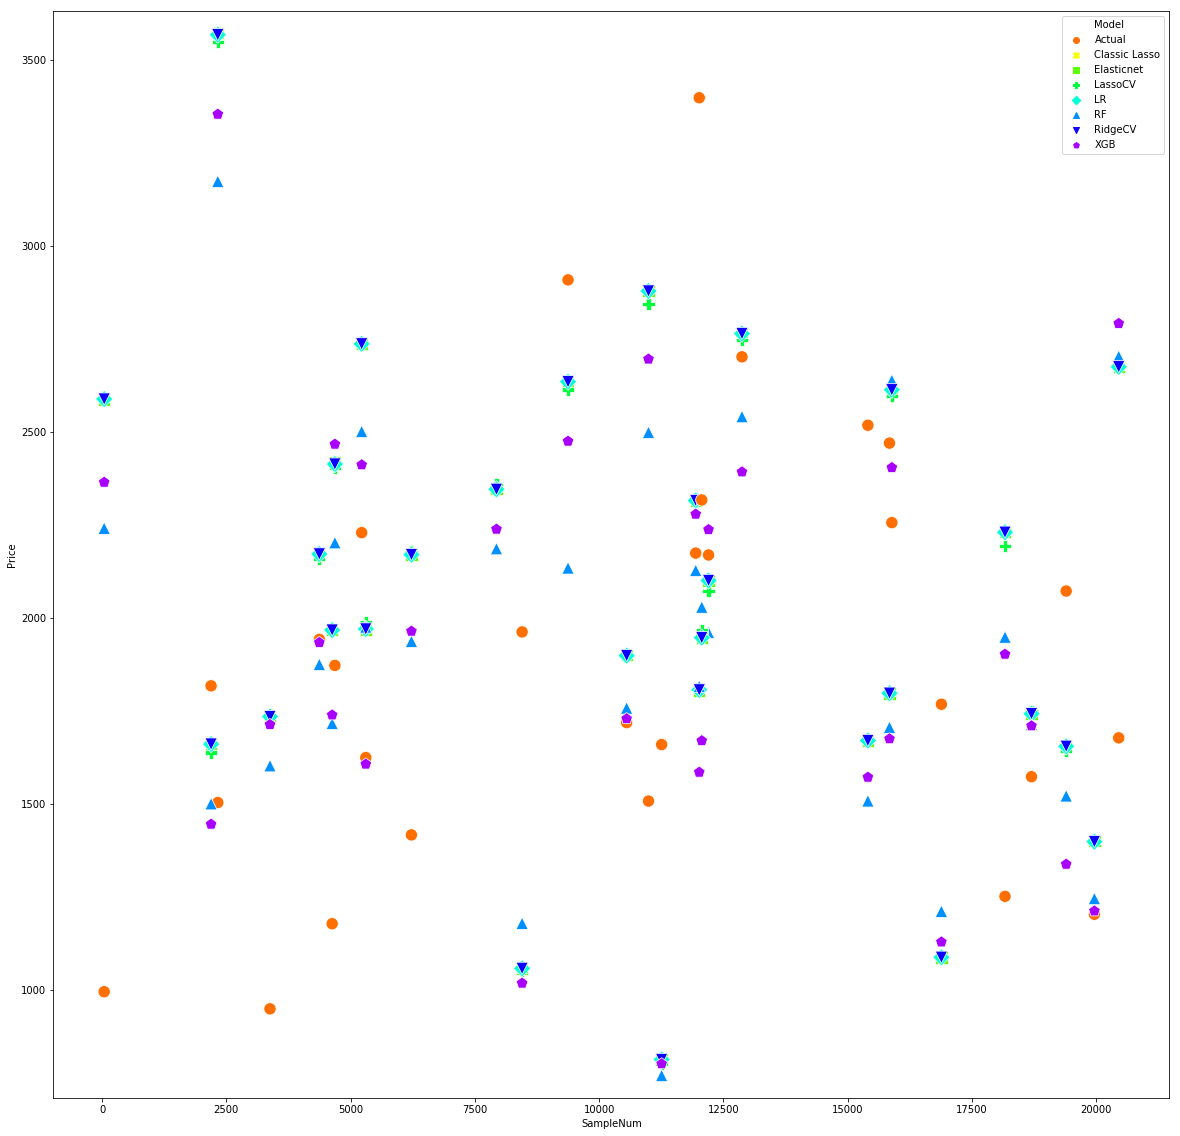

In [72]:
fig, ax = plt.subplots(figsize = (20, 20))

sns.scatterplot(x = "SampleNum", y = "Price", data = results1, hue = results1.Model, ax = ax, style = "Model", s = 150, palette = "gist_rainbow")
plt.legend(loc = "best")
plt.ylim(min(results1.Price)-60, max(results1.Price)+60)
plt.show()

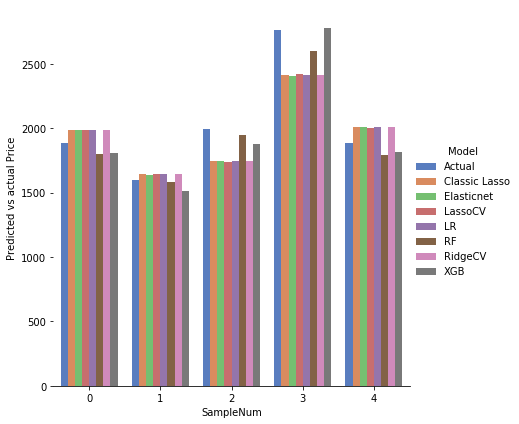

In [18]:
# fig, ax1 = plt.subplots(figsize = (12, 8))
g = sns.catplot(x = "SampleNum", y = "Price",hue = "Model",  data = results1, height=6, kind="bar", palette="muted")

g.despine(left=True)
g.set_ylabels("Predicted vs actual Price")

In [43]:
df_recs = pd.read_csv(os.path.join(dataFilePath, filename), low_memory= False)

In [63]:
totsqt = {0 : "df_recs.TOTHSQFT != -1",
             1 : "df_recs.TOTHSQFT < 900",
             2 : "df_recs.TOTHSQFT >= 900"}

In [58]:
print(totsqt[2])

df_recs.TOTHSQFT >= 900


In [64]:
df = df_recs[eval(totsqt[0])]
df.shape

(10, 196)